In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import galsim
from galsim.angle import radians, arcsec, degrees, AngleUnit
import numpy as np
import matplotlib.pylab as plt
import time
import sys

sys.path.append('/Users/andypark/Desktop/phd/batsim')

from astropy import wcs
from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

In [2]:
wcsfile = "./eimage_00182850-0-i-R22_S11-det000.fits"
f = fits.open(wcsfile)
w = WCS(f[0].header)
#w.wcs.cd *= 1. * arcsec / degrees
#w.sip.a[1, 0] += 1.
#w.sip.b[0, 1] += 1.

In [3]:
def get_radec(params, w, deg=False):
    params = jnp.asarray(params)
    params = params.astype(jnp.float64)
    u, v = get_uv(params, w)
    # 4) turn u, v into ra, dec
    cra, cdec = w.wcs.crval * degrees
    cra = cra.rad
    cdec = cdec.rad
    #u = u * radians / degrees
    #v = v * radians / degrees
    rsq = u * u
    rsq += v * v
    cosc = sinc_over_r = 1./jnp.sqrt(1.+rsq)
    sindec = v * sinc_over_r
    sindec *= jnp.cos(cdec)
    sindec += cosc * jnp.sin(cdec)
    tandra_num = u * sinc_over_r
    tandra_num *= -1.
    tandra_denom = v * sinc_over_r
    tandra_denom *= -jnp.sin(cdec)
    tandra_denom += cosc * jnp.cos(cdec)
    dec = jnp.arcsin(sindec)
    ra = cra + jnp.arctan2(tandra_num, tandra_denom)
    #center = galsim.CelestialCoord(w.wcs.crval[0] * degrees, w.wcs.crval[1] * degrees)
    #ra, dec = center.deproject_rad(u, v, "gnomonic")
    if deg:
        return ra * 180. / jnp.pi, dec * 180. / jnp.pi
    return ra, dec

def get_uv(params, w):
    params = jnp.asarray(params).astype(jnp.float32)
    x, y = params
    x -= w.wcs.crpix[0]
    y -= w.wcs.crpix[1] 

    ab = np.array([w.sip.a, w.sip.b])
    order = len(ab[0])-1
    xpow = x ** jnp.arange(order+1)
    ypow = y ** jnp.arange(order+1)
    p1 = jnp.dot(jnp.dot(ab, ypow), xpow)
    
    x += p1[0]
    y += p1[1]
    
    u, v = w.wcs.cd @ jnp.array([x, y])
    factor = 1. * degrees / radians
    u *= -factor
    v *= factor
    return u, v

# Galsim

In [8]:
wcs_g = galsim.GSFitsWCS(wcsfile)
skypos = wcs_g.toWorld(galsim.PositionI(0, 0))
skypos.ra.deg, skypos.dec.deg

(51.793908983991834, -40.26485572360853)

In [10]:
my_skypos = get_radec((0, 0), w, deg=True)
skypos.ra.deg / my_skypos[0], skypos.dec.deg / my_skypos[1]

(Array(1., dtype=float64), Array(1., dtype=float64))

# Manual?

Let $x, y$ be the relative pixel coordinates with origin at $\mathrm{CRPIX1}$ and $\mathrm{CRPIX2}$ and $u, v$ be the coordinates on the tangent plane of the celestial sphere
$$
\begin{pmatrix}u \\ v\end{pmatrix} = \begin{pmatrix}\mathrm{CD1\_1} & \mathrm{CD1\_1} \\ \mathrm{CD2\_1} & \mathrm{CD2\_2}\end{pmatrix}\begin{pmatrix}x + f(x, y) \\ y + g(x, y)\end{pmatrix}$$

The distortion matrix can be written as
$$
\begin{pmatrix}du \\ dv\end{pmatrix} = \begin{pmatrix}\partial_x u & \partial_y u \\ \partial_x v & \partial_y v\end{pmatrix}\begin{pmatrix}dx \\ dy\end{pmatrix} = M\begin{pmatrix}1 - g_1 & -g_2 + \theta \\ -g_2-\theta & 1+g_1\end{pmatrix}\begin{pmatrix}dx \\ dy\end{pmatrix}$$

and Field-Distortion Shear as
$$g_1(\mathrm{FD}) = (\partial_y v - \partial_x u) / (\partial_y v + \partial_x u)$$ and 
$$g_2(\mathrm{FD}) = -(\partial_x v - \partial_y u) / (\partial_y v + \partial_x u)$$

In [198]:
def get_radec(params, w, deg=False):
    params = jnp.asarray(params)
    params = params.astype(jnp.float64)
    u, v = get_uv(params, w)
    # 4) turn u, v into ra, dec
    cra, cdec = w.wcs.crval * degrees
    cra = cra.rad
    cdec = cdec.rad
    #u = u * radians / degrees
    #v = v * radians / degrees
    rsq = u * u
    rsq += v * v
    cosc = sinc_over_r = 1./jnp.sqrt(1.+rsq)
    sindec = v * sinc_over_r
    sindec *= jnp.cos(cdec)
    sindec += cosc * jnp.sin(cdec)
    tandra_num = u * sinc_over_r
    tandra_num *= -1.
    tandra_denom = v * sinc_over_r
    tandra_denom *= -jnp.sin(cdec)
    tandra_denom += cosc * jnp.cos(cdec)
    dec = jnp.arcsin(sindec)
    ra = cra + jnp.arctan2(tandra_num, tandra_denom)
    #center = galsim.CelestialCoord(w.wcs.crval[0] * degrees, w.wcs.crval[1] * degrees)
    #ra, dec = center.deproject_rad(u, v, "gnomonic")
    if deg:
        return ra * 180. / jnp.pi, dec * 180. / jnp.pi
    return ra, dec

In [199]:
def get_uv(params, w):
    params = jnp.asarray(params).astype(jnp.float32)
    x, y = params
    x -= w.wcs.crpix[0]
    y -= w.wcs.crpix[1] 

    ab = np.array([w.sip.a, w.sip.b])
    order = len(ab[0])-1
    xpow = x ** jnp.arange(order+1)
    ypow = y ** jnp.arange(order+1)
    p1 = jnp.dot(jnp.dot(ab, ypow), xpow)
    
    x += p1[0]
    y += p1[1]
    
    u, v = w.wcs.cd @ jnp.array([x, y])
    factor = 1. * degrees / radians
    u *= -factor
    v *= factor
    return u, v

In [215]:
shape = (64, 64)
indx = np.arange(shape[0], dtype=float)
indy = np.arange(shape[1], dtype=float)
inds = np.meshgrid(indy, indx, indexing="ij")
coords = jnp.vstack([np.ravel(_) for _ in inds[::-1]]).T

In [216]:
dget_uv = jax.vmap(jax.jacfwd(get_radec, 0), in_axes=[0, None])(coords, w)

In [217]:
du_dxy, dv_dxy = dget_uv
du_dx, du_dy = du_dxy.T
dv_dx, dv_dy = dv_dxy.T
g1_fd = (dv_dy - du_dx) / (dv_dy + du_dx)
g1_fd = np.reshape(g1_fd, shape)
g2_fd = -(dv_dx + du_dy) / (dv_dy + du_dx)
g2_fd = np.reshape(g2_fd, shape)

Text(0.5, 0, 'g')

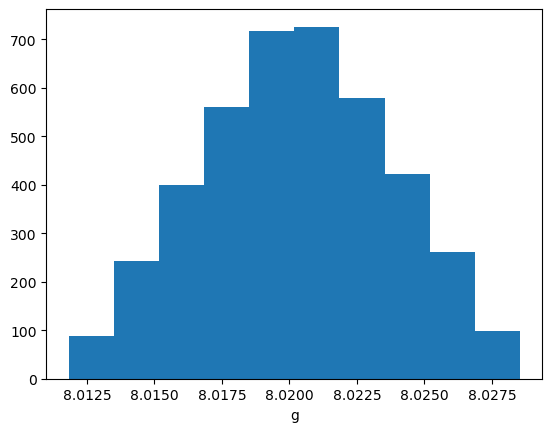

In [218]:
plt.hist(np.sqrt(g1_fd ** 2 + g2_fd ** 2).flatten())
plt.xlabel('g')

Text(0.5, 1.0, 'g2')

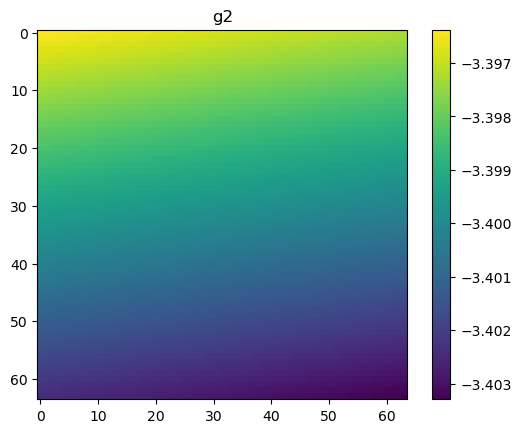

In [219]:
plt.imshow(g2_fd)
plt.colorbar()
plt.title('g2')

Text(0.5, 1.0, 'g1')

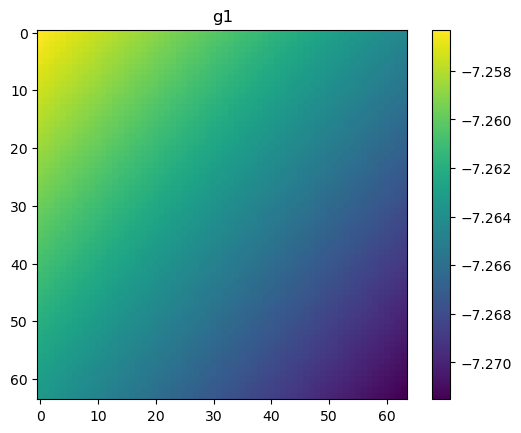

In [220]:
plt.imshow(g1_fd)
plt.colorbar()
plt.title('g1')

f = fits.open('./eimage_00182850-0-i-R22_S11-det000.fits')
w = WCS(f[0].header)

x, y = 0, 0

# 1) subtract off CRPIX
x -= w.wcs.crpix[0]
y -= w.wcs.crpix[1] 

# 2) SIP
w.sip.a[1, 0] += 1
w.sip.b[0, 1] += 1
f = 0
df_dx = 0
for p in range(w.sip.a_order+1):
    for q in range(w.sip.a_order+1):
        f += w.sip.a[p, q] * jnp.power(x, p) * jnp.power(y, q)
        df_dx += p * w.sip.a[p, q] * jnp.power(x, p-1) * jnp.power(y, q)
        
g = 0
dg_dx = 0
for p in range(w.sip.a_order+1):
    for q in range(w.sip.a_order+1):
        g += w.sip.b[p, q] * jnp.power(x, p) * jnp.power(y, q)
        dg_dx += p * w.sip.b[p, q] * jnp.power(x, p-1) * jnp.power(y, q)

x += f
y += g

# 3) Apply CD
u, v = w.wcs.cd @ np.array([x, y])
print(u, v)
factor = 1. * degrees / radians
u *= -factor
v *= factor

# 4) turn u, v into ra, dec
center = galsim.CelestialCoord(w.wcs.crval[0] * degrees, w.wcs.crval[1] * degrees)
ra, dec = center.deproject_rad(u, v, "gnomonic")
ra *= radians / degrees

In [44]:
w.sip.a.shape

(4, 4)

In [67]:
ab = np.array([w.sip.a, w.sip.b])

In [69]:
ab.shape

(2, 4, 4)

In [70]:
x, y = 3, 10
order = len(w.sip.a[0])-1
xpow = x ** np.arange(order+1)
ypow = y ** np.arange(order+1)
p1 = np.dot(np.dot(ab, ypow), xpow)

In [77]:
jac = np.diag([1, 1])

In [79]:
dxpow = np.zeros(order+1)
dypow = np.zeros(order+1)
dxpow[1:] = (np.arange(order)+1.) * xpow[:-1]
dypow[1:] = (np.arange(order)+1.) * ypow[:-1]
j1 = np.transpose([np.dot(np.dot(ab, ypow), dxpow),
                   np.dot(np.dot(ab, xpow), dypow)])
jac = np.dot(j1, jac)

In [81]:
p2 = np.dot(w.wcs.cd, p1)
jac = np.dot(w.wcs.cd, jac)

In [85]:
unit_covert = [-1 * degrees / radians, 1 * degrees / radians]
p2 *= unit_covert

In [87]:
jac = jac * np.transpose([unit_covert])

In [98]:
cra, cdec = w.wcs.crval
cra = cra * np.pi / 180
cdec = cdec * np.pi / 180

def jac_deproject(u, v):
    rsq = u*u + v*v
    rsq1 = (u+1.e-4)**2 + v**2
    rsq2 = u**2 + (v+1.e-4)**2
    c = s = 1./np.sqrt(1.+rsq)
    s3 = s*s*s
    dcdu = dsdu = -u*s3
    dcdv = dsdv = -v*s3
    s0 = np.sin(cdec)
    c0 = np.cos(cdec)
    sindec = c * s0 + v * s * c0
    cosdec = np.sqrt(1.-sindec*sindec)
    dddu = ( s0 * dcdu + v * dsdu * c0 ) / cosdec
    dddv = ( s0 * dcdv + (v * dsdv + s) * c0 ) / cosdec

    tandra_num = u * s
    tandra_denom = c * c0 - v * s * s0
    
    A2sec2dra = tandra_denom**2 + tandra_num**2
    drdu = ((u * dsdu + s) * tandra_denom - u * s * ( dcdu * c0 - v * dsdu * s0 ))/A2sec2dra
    drdv = (u * dsdv * tandra_denom - u * s * ( dcdv * c0 - (v * dsdv + s) * s0 ))/A2sec2dra

    drdu *= cosdec
    drdv *= cosdec
    return np.array([[drdu, drdv], [dddu, dddv]])

j2 = jac_deproject(p2[0], p2[1])
jac = np.dot(j2, jac)

jac *= radians / arcsec


In [128]:
jac, test

(array([[-0.18113955, -0.18113955],
        [ 0.08500092,  0.08500092]]),
 galsim.JacobianWCS(-0.1813237293527408, -0.0846045658884356, 0.08459759819988825, -0.18130939375149208))

In [100]:
dxxi = jac[0, 0]
dyxi = jac[0, 1]
dxeta = jac[1, 0]
dyeta = jac[1, 1]

In [101]:
(dyeta - dxxi) / (dyeta + dxxi)

-2.768299052331508

In [102]:
-(dxeta + dyxi) / (dyeta + dxxi)

-1.0000000061155512

In [107]:
center = galsim.CelestialCoord(w.wcs.crval[0] * degrees, w.wcs.crval[1] * degrees)

In [112]:
jac

array([[-0.18113955, -0.18113955],
       [ 0.08500092,  0.08500092]])

In [113]:
j2 = jac_deproject(p2[0], p2[1])

In [111]:
center.jac_deproject_rad(p2[0], p2[1])

array([[ 1.00000000e+00,  5.73305056e-06],
       [-5.73310153e-06,  1.00000000e+00]])

In [119]:
test = wcs_g._local(galsim.PositionI(3, 3))

In [124]:
test

galsim.JacobianWCS(-0.1813237293527408, -0.0846045658884356, 0.08459759819988825, -0.18130939375149208)

In [123]:
test.dudx

-0.1813237293527408

In [126]:
dxxi = test.dudx
dyxi = test.dudy
dxeta = test.dvdx
dyeta = test.dvdy
(dyeta - dxxi) / (dyeta + dxxi), -(dxeta + dyxi) / (dyeta + dxxi)

(-3.953196863542207e-05, -1.9214153653961746e-05)